In [507]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import calendar
# import dask
from datetime import datetime
%matplotlib inline

In [833]:
# SET ALL THE OPTIONS #
hist = 'a22q'
pred = 'a0pe'
var = 'siextentn'
mon_ini = '11' # '05'
ini_hist = '19700101'
year1 = 1992
year2 = 1993
mem_hist1 = 2
mem_hist2 = 5
mem_pred1 = 12
mem_pred2 = 15
freq = 'mon'
path1 = '/esarchive/exp/ecearth/'
path2 = '/cmorfiles/EC-Earth-Consortium/EC-Earth3-LR/historical/'
path3 = '/cmorfiles/BSC/EC-EARTH3/' 
compo = 'OImon'
mod_compo = 'seaIce'
vdate = 'v20190201'
path_out = '/esarchive/scratch/ruben/notebooks/'

reg = 'TotalArc'

members_hist = []
for r in range(mem_hist1, mem_hist2+1):
    me_hist = 'r{0}i1p1'.format(r)
    members_hist.append(me_hist)

members_pred = []
for r in range(mem_pred1, mem_pred2+1):
    me_pred = 'r{0}i1p1'.format(r)
    members_pred.append(me_pred)

chunks_hist = []
for y in range(year1, year2+2): # One more year than in PRED (for compatibility in Hindcast mode)
    chuhist = '{0}01-{1}12'.format(str(y), str(y))
    chunks_hist.append(chuhist)
    
chunks_pred = []
for j in range(year1, year2+1):
    if mon_ini == '11':
        chupred = '{0}11-{1}05'.format(str(j), str(j+1))
    elif mon_ini == '05':
        chupred = '{0}11-{1}05'.format(str(j), str(j+1))
    chunks_pred.append(chupred)

## Load Historical Simulation

In [834]:
HIST = []
for mem in members_hist:
    filenames_hist = []
    for chu in chunks_hist:
        file_path_hist = '{0}{1}{2}S{3}/{4}/{5}/{6}/{7}'.format(path1, hist, path2, ini_hist, freq, mod_compo, var, mem)

        filename = glob.glob(file_path_hist + '/v*/' + var + '_' + compo + '_EC-Earth3-LR_historical_S'
                             + ini_hist + '_' + mem + '_' + chu + '.nc')
        filenames_hist.append(filename[0])

    f_list_hist = sorted(filenames_hist)

    list_hist = []
    format_date = '%Y%m'
    for file_hist in f_list_hist:
        year = file_hist.split(".")[0].split("-")[-2].split("_")[-1] + '-' + file_hist.split(".")[0].split("-")[-1]
        ds_hist = xr.open_dataset(file_hist, decode_times=False) 
        index_mensuel = xr.cftime_range(year.split("-")[0], periods=12, freq='MS') # Monthly-Start
        ds_hist.coords['time'] = index_mensuel
        list_hist.append(ds_hist)
    ds_a2yd_hist = xr.concat(list_hist, dim='time') 
    ds_a2yd_hist = ds_a2yd_hist.sortby('time')
    HIST.append(ds_a2yd_hist)

historical = xr.DataArray(members_hist, name='member', dims='member')
ds_hist = xr.concat(HIST, dim=historical)

In [835]:
# Histo2Hindcast # ONLY FOR ENSEMBLE MEAN
reg_byte = str.encode(reg)
hist_reg = ds_hist.sel(region=reg_byte)
hist_ensemble = hist_reg.mean(dim='member')

formatted_HIST = []
for s_dates in range(0, len(chunks_pred)):
    forecast_period = chunks_pred[s_dates]
    first_step = forecast_period.split('-')[0]
    last_step = forecast_period.split('-')[1]
    start_slice = '-'.join([first_step[:4], first_step[-2:]])
    end_slice = '-'.join([last_step[:4], last_step[-2:]])
    

    k = hist_ensemble.sel(time=slice(start_slice, end_slice))
    k['time'] = np.arange(1, 8) # forecast time
    formatted_HIST.append(k)

sdates_dim = xr.DataArray(chunks_pred, name='sdate', dims='sdate')
reshaped_HIST = xr.concat(formatted_HIST, dim=sdates_dim)

In [816]:
# # Histo2Hindcast # WITH MEMBERS
# reg = 'TotalArc'
# reg_byte = str.encode(reg)
# hist_reg = ds_hist.sel(region=reg_byte)

# sdates_dim = xr.DataArray(chunks_pred, name='sdate', dims='sdate')

# # formatted_HIST = []
# for mem in members_hist:
#     formatted_HIST = []
#     k = hist_reg.sel(member=mem)
#     for chun in range(0, len(chunks_pred)):
#         forecast_period = chunks_pred[chun]
#         first_step = forecast_period.split('-')[0]
#         last_step = forecast_period.split('-')[1]
#         start_slice = '-'.join([first_step[:4], first_step[-2:]])
#         end_slice = '-'.join([last_step[:4], last_step[-2:]])
#         kk = k.sel(time=slice(start_slice, end_slice))   #.values
#         formatted_HIST.append(kk)
#         print(formatted_HIST)
#     reshaped_HIST_chunk = xr.concat(formatted_HIST, dim=sdates_dim)

# #     print(reshaped_HIST_chunk)
    
# # sdates_dim = xr.DataArray(chunks_pred, name='sdate', dims='sdate')
# # reshaped_HIST = xr.concat(formatted_HIST, dim=sdates_dim)
# #     print(k)
# # formatted_HIST

## Load Forecasts

In [836]:
HIND = []
for mem in members_pred:
    filenames_pred = []
    for chu in chunks_pred:
    
        start_date = chu.split('-')[0]  
        file_path_pred = '{0}{1}{2}{3}/S{4}01/{5}/{6}/{7}/{8}'.format(path1, pred, path3, pred,
                                                            start_date, freq, mod_compo, var, mem)
        filename_ = glob.glob(file_path_pred + '/' + var + '_' + compo + '_EC-EARTH3_' + pred + '_S' +
                              start_date + '01_' + mem + '_' + chu + '.nc') 
        filenames_pred.append(filename_[0])
   
    f_list_pred = sorted(filenames_pred)
    
    list_pred = []
    for file_ in f_list_pred:
        ds = xr.open_dataset(file_, decode_times=False)
        ds['time'] = np.arange(1, 8) # forecast time
        list_pred.append(ds)
        
    da_num_pred = xr.DataArray(chunks_pred, name='sdate', dims='sdate')
    ds_pred_num = xr.concat(list_pred, dim=da_num_pred)
    
    HIND.append(ds_pred_num)

hindcast = xr.DataArray(members_pred, name='member', dims='member')
ds_hind = xr.concat(HIND, dim=hindcast)

## Load Observations

In [ ]:
# NSIDC





In [844]:
# CLIMATOLOGIES IN FORECAST MODE
# reg_byte = str.encode(reg)
# hist_reg = ds_hist.sel(region=reg_byte)

pred_reg = ds_hind.sel(region=reg)
pred_ensemble = pred_reg[var].mean(dim='member')
pred_clim = pred_ensemble.mean(dim='sdate')
print(pred_clim.values)

hist_clim = reshaped_HIST[var].mean(dim='sdate')
print(hist_clim.values)

[10.54384444 12.55436612 13.72180828 14.34599385 14.56521606 13.90225605
 12.07597898]
[12.84776985 15.00763731 16.17849994 16.67265318 16.77213001 16.48634888
 15.28360652]


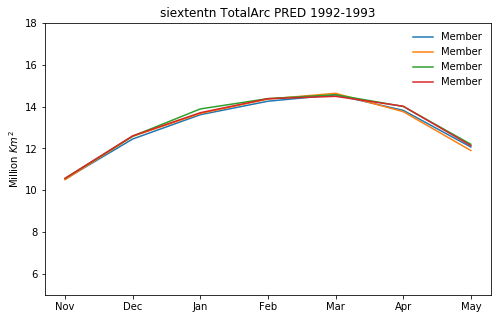

In [552]:
# TEST PRED members (plot)
# calendar starting in Nov
month_lst = []
for m in range(11,13):
    month_lst.append(calendar.month_abbr[m])
    if m == 12:
        for n in range(1, 6):
            month_lst.append(calendar.month_abbr[n])
            
pred_meandates = pred_reg[var].mean(dim='sdate') 

fig, ax = plt.subplots(figsize=(8,5))

for l in range(0, len(pred_meandates[:,1])):
    plt.plot(np.arange(1,8), pred_meandates[l,:], label='Member')
plt.ylabel('Million $Km^2$')
plt.ylim(5,18)
plt.xticks(range(1, 8), month_lst)
plt.title('{0} {1} PRED {2}-{3}'.format(var, reg, year1, year2))
plt.legend(frameon=False)
plt.show()
# plt.savefig(path_out + variable + '_Northern_Hemisphere_September_50ans_a2xx_HR_tuning_exp.png', bbox_inches='tight', dpi=150)

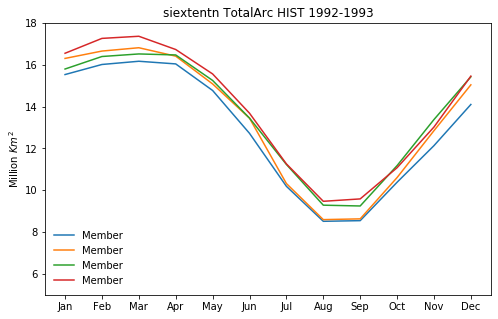

In [554]:
# TEST HIST members (plot)
month_lst = []
for m in range(1,13):
    month_lst.append(calendar.month_abbr[m])
            
hist_meandates = hist_reg[var].groupby("time").mean()

hist_meanmembers = []
for m in range(0, len(members_pred)):
    hist_miembro = hist_reg[var][m].groupby("time.month").mean()
    hist_meanmembers.append(hist_miembro)

fig, ax = plt.subplots(figsize=(8,5))
for l in range(0, len(members_hist)):
    plt.plot(np.arange(1,13), hist_meanmembers[l], label='Member')
plt.ylabel('Million $Km^2$')
plt.ylim(5,18)
plt.xticks(range(1, 13), month_lst)
plt.title('{0} {1} HIST {2}-{3}'.format(var, reg, year1, year2))
plt.legend(frameon=False)
plt.show()

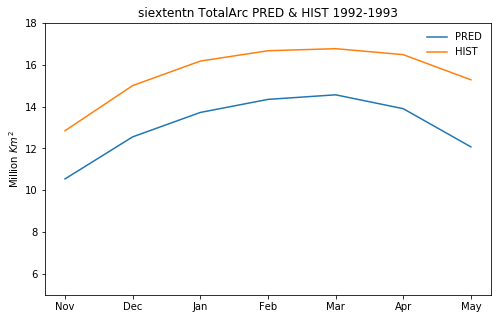

In [845]:
# PRED and HIST comparison #
# calendar starting in Nov
month_lst = []
for m in range(11,13):
    month_lst.append(calendar.month_abbr[m])
    if m == 12:
        for n in range(1, 6):
            month_lst.append(calendar.month_abbr[n])
            
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.arange(1,8), pred_clim, label='PRED')
plt.plot(np.arange(1,8), hist_clim, label='HIST')
plt.ylabel('Million $Km^2$')
plt.ylim(5,18)
plt.xticks(range(1, 8), month_lst)
plt.title('{0} {1} PRED & HIST {2}-{3}'.format(var, reg, year1, year2))
plt.legend(frameon=False)
plt.show()